In [1]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import tensorflow as tf

In [2]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [3]:
train = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/train')
test = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/test')
val = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/val')

OpenCV(4.2.0) /io/opencv/modules/imgproc/src/resize.cpp:4045: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.2.0) /io/opencv/modules/imgproc/src/resize.cpp:4045: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.2.0) /io/opencv/modules/imgproc/src/resize.cpp:4045: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.2.0) /io/opencv/modules/imgproc/src/resize.cpp:4045: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



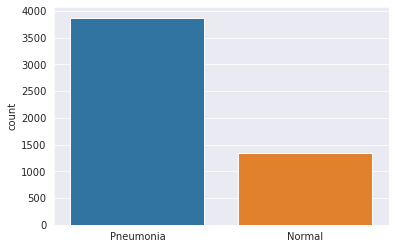

In [4]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)        

Text(0.5, 1.0, 'NORMAL')

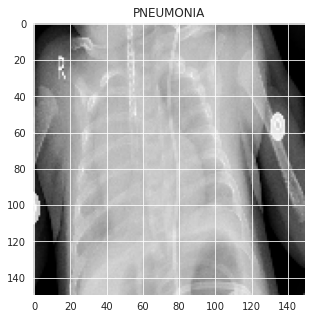

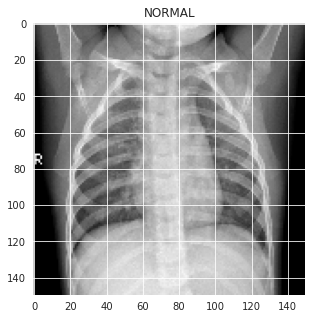

In [35]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [6]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [7]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255


In [8]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)


In [9]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 64)        0

In [10]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000000000001)

In [11]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        #shear_range=0.2,
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [22]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 24 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])
tl,ts=model.evaluate(x_test, y_test, batch_size=32)
print(tl)
print(ts)

Epoch 1/2
163/163 [==============================] - 10s 64ms/step - loss: 0.0927 - accuracy: 0.9643 - val_loss: 0.9216 - val_accuracy: 0.7500 - lr: 5.9049e-09
Epoch 2/2
20/20 [==============================] - 0s 7ms/step - loss: 0.2916 - accuracy: 0.9006
0.29158565402030945
0.9006410241127014


In [14]:
tl,ts=model.evaluate(x_test, y_test, batch_size=32)
print(tl)
print(ts)

20/20 [==============================] - 0s 7ms/step - loss: 0.2860 - accuracy: 0.9151
0.28596216440200806
0.9150640964508057


In [15]:
dp=0.6
model3 = Sequential()
model3.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model3.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model3.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model3.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model3.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model3.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model3.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model3.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model3.add(Flatten())
model3.add(Dropout(0.2))
model3.add(Dense(units = 512 , activation = 'relu'))
model3.add(Dense(units = 1 , activation = 'sigmoid'))
model3.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 150, 150, 32)      320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 38, 38, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 19, 19, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 19, 19, 128)      

In [16]:
dp=0.1
model4 = Sequential()
model4.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
#model4.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (256,256,1)))
model4.add(BatchNormalization())
model4.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model4.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model4.add(Dropout(dp))
model4.add(BatchNormalization())
model4.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model4.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model4.add(BatchNormalization())
model4.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model4.add(Conv2D(512 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model4.add(Dropout(dp))
model4.add(BatchNormalization())
model4.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model4.add(Conv2D(1024 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model4.add(Dropout(dp))
model4.add(BatchNormalization())
model4.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model4.add(Conv2D(1024 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model4.add(Dropout(0.4))
model4.add(BatchNormalization())
model4.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model4.add(Flatten())
model4.add(Dense(units = 128 , activation = 'relu'))
model4.add(Dropout(dp))
model4.add(Dense(units = 1 , activation = 'sigmoid'))
model4.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model4.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 150, 150, 64)      640       
_________________________________________________________________
batch_normalization_5 (Batch (None, 150, 150, 64)      256       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 75, 75, 128)       73856     
_________________________________________________________________
dropout_5 (Dropout)          (None, 75, 75, 128)       0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 75, 75, 128)       512       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 38, 38, 128)      

In [1]:
history = model3.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 24 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])
t1,t2=model3.evaluate(x_test, y_test, batch_size=32)
print(t1)
print(t2)

NameError: name 'model3' is not defined

In [18]:
history = model4.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 24 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])
t1,t2=model4.evaluate(x_test, y_test, batch_size=32)
print(t1)
print(t2)

Epoch 1/12
163/163 [==============================] - 15s 89ms/step - loss: 0.5571 - accuracy: 0.8158 - val_loss: 71.3161 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/12
163/163 [==============================] - 13s 81ms/step - loss: 0.2921 - accuracy: 0.8823 - val_loss: 50.3144 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/12
163/163 [==============================] - ETA: 0s - loss: 0.2112 - accuracy: 0.9250
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 13s 82ms/step - loss: 0.2112 - accuracy: 0.9250 - val_loss: 56.3850 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/12
163/163 [==============================] - 13s 82ms/step - loss: 0.1464 - accuracy: 0.9482 - val_loss: 1.1008 - val_accuracy: 0.5625 - lr: 3.0000e-04
Epoch 5/12
163/163 [==============================] - 15s 89ms/step - loss: 0.1339 - accuracy: 0.9525 - val_loss: 0.6956 - val_accuracy: 0.6250 - lr: 3.0000e-04
Epoch 6/12
163/163 [===================

KeyboardInterrupt: 

In [19]:
t1,t2=model4.evaluate(x_test, y_test, batch_size=32)
print(t1)
print(t2)

20/20 [==============================] - 0s 18ms/step - loss: 0.8375 - accuracy: 0.7228
0.8374899625778198
0.7227563858032227


In [20]:
#y1=model3.predict(x_test)
y2=model.predict_classes(x_test)
y3=np.zeros((624,1))
#y4=model4.predict(x_test)
print(classification_report(y_test, y2, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))


                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.91      0.93      0.92       390
   Normal (Class 1)       0.88      0.85      0.87       234

           accuracy                           0.90       624
          macro avg       0.90      0.89      0.90       624
       weighted avg       0.90      0.90      0.90       624



In [40]:
export_dir='PNMN'
tf.saved_model.save(model,export_dir)

In [41]:
converter=tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model=converter.convert()

with open('pnmn2.tflite','wb') as f:
  f.write(tflite_model)

In [43]:
from IPython.display import FileLink
FileLink(r'pnmn2.tflite')

/kaggle/working/pnmn2.tflite